# Analysis of the Cervical Cancer Dataser from CodeHerCare

This notebook contains step-by-step analysis of attributes that contribute to the risk of women developing cervical cancer.

Data source : CodeHerCare

Steps:

1. Understanding the data
2. Cleaning data
3. Feature Engineering 
4. Modelling
5. Testing
6. Deploying

Step 3, 4, 5 are iterative until we find the correct features for risk assessment

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for handling categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# libraries for handling missing values
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# libraries for normalization and scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# libraries for model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit

# libraries for clustering
from sklearn.cluster import KMeans, DBSCAN

# libraries for dimensionality reduction
from sklearn.decomposition import PCA, TruncatedSVD

# model libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# libraries for model evaluation
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

import joblib

# suppress warningsimport warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the dataset
cerv_data = 'data/Cervical Cancer Datasets_.xlsx'
cerv_df = pd.read_excel(cerv_data, sheet_name='Cervical Cancer Risk Factors')
cerv_df.head()

,Patient ID,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action,Unnamed: 12
0,P0001,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,NaN
1,P0002,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
2,P0003,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
3,P0004,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",NaN
4,P0005,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN


## Data Understanding

In [3]:
cerv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Patient ID                 100 non-null    object
 1   Age                        100 non-null    int64 
 2   Sexual Partners            100 non-null    int64 
 3   First Sexual Activity Age  100 non-null    int64 
 4   HPV Test Result            100 non-null    object
 5   Pap Smear Result           100 non-null    object
 6   Smoking Status             100 non-null    object
 7   STDs History               100 non-null    object
 8   Region                     100 non-null    object
 9   Insrance Covered           100 non-null    object
 10  Screening Type Last        100 non-null    object
 11  Recommended Action         100 non-null    object
 12  Unnamed: 12                1 non-null      object
dtypes: int64(3), object(10)
memory usage: 10.3+ KB


## Info

- there are 13 features in the dataset, each feature containing 100 instances
- 3 of the feature, `Age`, `Sexual Partners`, `First Sexual Activity Age`, are in numerical form and the rest of the feature are in categorical form
- The `unnamed: 12` columns contains 99 missing values, we will drop them
- The patient ID doesn't contribute much in this dataset

In [4]:
# statistical description
cerv_df.describe()

,Age,Sexual Partners,First Sexual Activity Age
count,100.000000,100.000000,100.000000
mean,37.430000,2.740000,18.830000
std,10.961139,1.432805,5.630105
min,15.000000,1.000000,2.000000
25%,34.000000,2.000000,16.000000
50%,36.000000,3.000000,18.000000
75%,40.000000,3.000000,20.000000
max,89.000000,9.000000,57.000000


## describe info

- `Age` - this features contains the different Ages of the patient
  - the mean age is 37
  - the deviation from the mean is 10, we will compare it with the mean (CV = 10/37 = 0.27027)
  - the minimum age is 15 years, the maximum age is 89 years

- `Sexual Partners` - this feature contains the number of number of sexual patners the patient has
  - the mean is 2 sexual partners
  - the deviation from the mean is 1.4
  - the minimum sexual partners is 1 and the maximum is 9

- `First Sexual Activity Age` - this feature contains the age when the patient had her first sexual intercourse
  - the mean is 18 years
  - the std is 5 years
  - and the min age is 2🤨, max age is 57 years

## Numerical Analysis

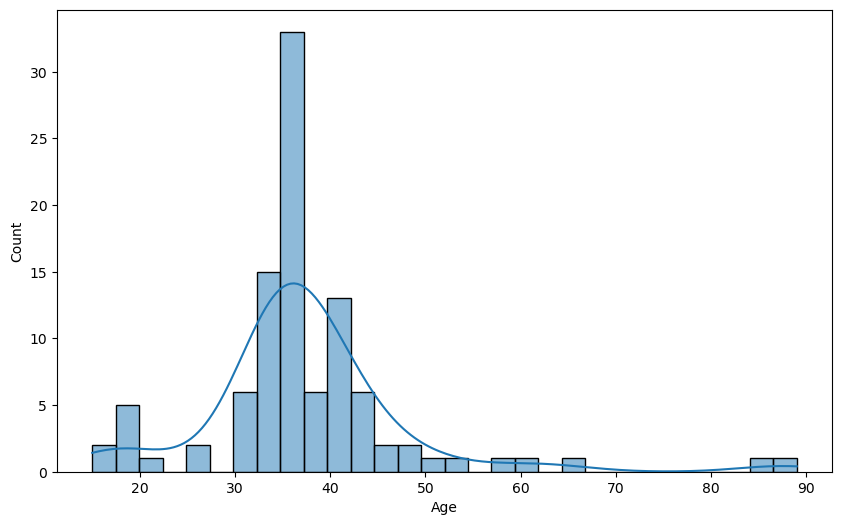

In [5]:
# Age
plt.figure(figsize=(10, 6))
sns.histplot(cerv_df['Age'], bins=30, kde=True);

Age: 
- Positively skewed with a long tail, majority of the patients in this dataset are between 34 and 44
- the older generation contribute to the long tail between 50 - 89
- this imbalance may cause the model to overfit

To be done:
- Normalization
- Binning

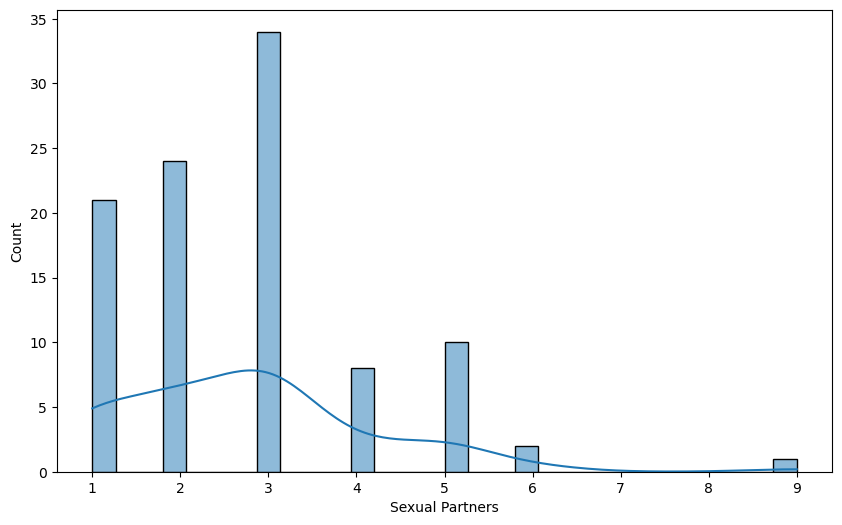

In [6]:
# sexual partners
plt.figure(figsize=(10, 6))
sns.histplot(cerv_df['Sexual Partners'], bins=30, kde=True);

Sexual Partners:
- Even thought there number of sexual partners are between 1 and 9, it will be a continuous variable (In the application, any value beyond 9 will be represented as 9 and a user cannot enter a negative vaule)

To do:
- Normalization (min-max scaling)

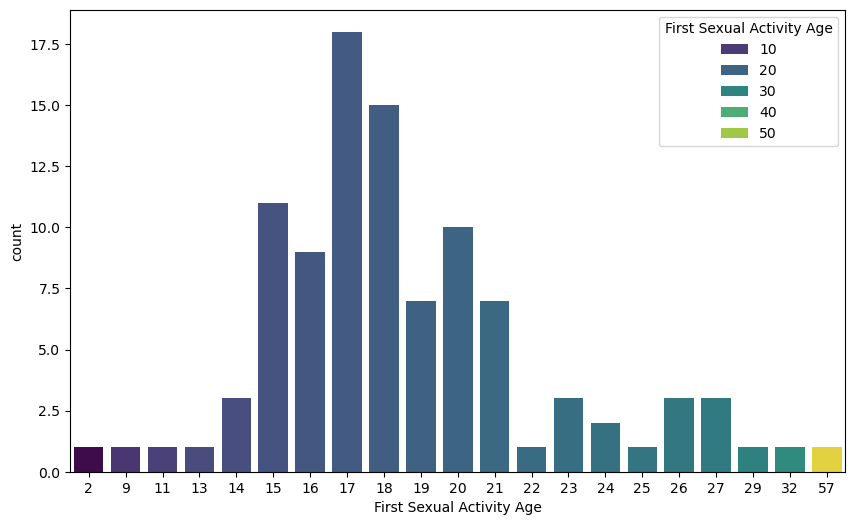

In [7]:
# First Sexual Intercourse Age
plt.figure(figsize=(10, 6))
sns.countplot(data=cerv_df, x='First Sexual Activity Age', palette='viridis', hue='First Sexual Activity Age');

First sexual activity age:
- similar to the age feature, the same preprocessing will be done

## Categorical Analysis

In [9]:
cerv_df.head()

,Patient ID,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action,Unnamed: 12
0,P0001,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,NaN
1,P0002,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
2,P0003,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
3,P0004,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",NaN
4,P0005,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN


In [10]:
# HPV Test Result
cerv_df['HPV Test Result'].value_counts()

HPV Test Result
NEGATIVE      47
POSITIVE      46
POSITIVE\n     6
NEGAGTIVE      1
Name: count, dtype: int64

HPV Test Result:

Incorrect spelling of positive and negative

To do: rename instances

In [8]:
cerv_df['HPV Test Result'] = cerv_df['HPV Test Result'].replace({'NEGAGTIVE': 'NEGATIVE' , 'POSITIVE\n': 'POSITIVE'})
cerv_df['HPV Test Result'].value_counts()

HPV Test Result
POSITIVE    52
NEGATIVE    48
Name: count, dtype: int64

The positive and negative HPV results are balanced.

In [9]:
# smoking status
cerv_df['Smoking Status'].value_counts()

Smoking Status
N    60
Y    40
Name: count, dtype: int64

In [10]:
# STDs History
cerv_df['STDs History'].value_counts()


STDs History
N    52
Y    48
Name: count, dtype: int64

In [11]:
# Pap Smear Result
cerv_df['Pap Smear Result'].value_counts()

Pap Smear Result
N    65
Y    35
Name: count, dtype: int64

In [12]:
cerv_df['Screening Type Last'].value_counts()

Screening Type Last
PAP SMEAR    39
VIA          31
HPV DNA      30
Name: count, dtype: int64

Screening Type Last:
- PAP SMEAR
- VIA - highly recommended in low resource settings
- HPV DNA

In [16]:
# regions
cerv_df['Region'].value_counts()

Region
Embu         14
Kericho      11
Mombasa      10
Kitale        9
Loitoktok     9
Kakamega      8
Machakos      7
Mombasa       5
Moi           5
Pumwani       4
Pumwani       3
Kitale        3
Machakos      2
Garissa       2
Garissa       2
Moi           2
Kericho       2
Kakamega      1
NAKURU        1
Name: count, dtype: int64

In [17]:
# recommended action
cerv_df['Recommended Action'].value_counts()

Recommended Action
REPEAT PAP SMEAR IN 3 YEARS                                 25
FOR COLPOSCOPY BIOPSY, CYTOLOGY                             11
FOR PAP SMEAR                                                9
FOR HPV VACCINE AND SEXUAL EDUCATION                         7
FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS                 7
FOR ANNUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS                5
REPEAT PAP SMEAR IN 3 YEARS                                  5
FOR COLPOSCOPY BIOPSY, CYTOLOGY                              5
FOR COLPOSCOPY BIOSPY, CYTOLOGY                              4
FOR COLOSCOPY BIOSY, CYTOLOGY                                3
REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE              2
FOR HPV VACCINATION AND SEXUAL EDUCATION                     2
FOR COLPOSCOPY CYTOLOGY AND BIOPSY                           1
FOR BIOPSY AND CYTOLOGY WITH TAH NOT RECOMMENDED             1
FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION              1
FOR COLPOSCOPY BIOSY, CYTOLOGY+/- TA

## Data Cleaning

In [18]:
cerv_df.head()

,Patient ID,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action,Unnamed: 12
0,P0001,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,NaN
1,P0002,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
2,P0003,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
3,P0004,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",NaN
4,P0005,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN


In [13]:
# drop unnecessary columns
cerv_df = cerv_df.drop(columns=['Unnamed: 12', 'Patient ID'], axis=1)
cerv_df.head()

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action
0,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE
1,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
2,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
3,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION"
4,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION


In [14]:
# drop the outlier in first sexual activity age
cerv_df_outlier = cerv_df[cerv_df['First Sexual Activity Age'] <= 2]
cerv_df_outlier

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action
86,19,2,2,POSITIVE,Y,N,N,Kitale,Y,HPV DNA,"FOR COLOSCOPY BIOSY, CYTOLOGY"


In [15]:
cerv_df = cerv_df.drop(cerv_df[cerv_df['First Sexual Activity Age'] <= 2].index)
cerv_df

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action
0,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE
1,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
2,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
3,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION"
4,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
...,...,...,...,...,...,...,...,...,...,...,...
95,31,4,16,POSITIVE,Y,Y,N,Machakos,N,PAP SMEAR,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"
96,35,5,11,NEGATIVE,N,Y,N,Mombasa,N,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS
97,35,1,18,POSITIVE,N,Y,N,Kericho,N,HPV DNA,FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS
98,31,1,20,POSITIVE,Y,Y,N,Embu,Y,HPV DNA,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"


## Risk Assessment

In [16]:
cerv_df

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action
0,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE
1,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
2,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
3,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION"
4,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
...,...,...,...,...,...,...,...,...,...,...,...
95,31,4,16,POSITIVE,Y,Y,N,Machakos,N,PAP SMEAR,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"
96,35,5,11,NEGATIVE,N,Y,N,Mombasa,N,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS
97,35,1,18,POSITIVE,N,Y,N,Kericho,N,HPV DNA,FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS
98,31,1,20,POSITIVE,Y,Y,N,Embu,Y,HPV DNA,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"


In [17]:
cerv_risk_attr = cerv_df.drop(columns=['Pap Smear Result', 'Recommended Action', 'Region', 'Screening Type Last', 'Insrance Covered'], axis=1)
cerv_risk_attr.head()

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Smoking Status,STDs History
0,18,4,15,NEGATIVE,N,Y
1,15,1,14,POSITIVE,Y,Y
2,34,1,9,POSITIVE,N,Y
3,52,5,16,POSITIVE,Y,N
4,46,3,21,POSITIVE,N,N


### Feature Engineering

In [23]:
cerv_risk_attr['Years_Sexually_Active'] = cerv_risk_attr['Age'] - cerv_risk_attr['First Sexual Activity Age']

# Map categorical columns to numeric
smoking_map = {'N': 0, 'Y': 1}
stds_map = {'N': 0, 'Y': 1}
hpv_map = {'NEGATIVE': 0, 'POSITIVE': 1}

cerv_risk_attr['Smoking_Status_Num'] = cerv_risk_attr['Smoking Status'].map(smoking_map)
cerv_risk_attr['STDs_History_Num'] = cerv_risk_attr['STDs History'].map(stds_map)
cerv_risk_attr['HPV_Test_Result_Num'] = cerv_risk_attr['HPV Test Result'].map(hpv_map)

cerv_risk_attr['Risk_Score'] = (
    cerv_risk_attr['Sexual Partners'] / 5 +
    (cerv_risk_attr['Years_Sexually_Active'] / 30) +
    cerv_risk_attr['Smoking_Status_Num'] +
    cerv_risk_attr['STDs_History_Num']
)

In [19]:
# smokes and has stds
cerv_risk_attr['Smokes_and_Has_STDs'] = cerv_risk_attr['Smoking_Status_Num'] * cerv_risk_attr['STDs_History_Num']

# sexual partner and years active
cerv_risk_attr['Sexual_Partner_and_Years_Active'] = cerv_risk_attr['Sexual Partners'] * cerv_risk_attr['Years_Sexually_Active']

In [41]:
cerv_risk_attr['HPV_and_STDs'] = cerv_risk_attr['HPV_Test_Result_Num'] * cerv_risk_attr['STDs_History_Num']
cerv_risk_attr['HPV_and_Smoking'] = cerv_risk_attr['HPV_Test_Result_Num'] * cerv_risk_attr['Smoking_Status_Num']
cerv_risk_attr['High_Risk_Score'] = (cerv_risk_attr['Risk_Score'] > cerv_risk_attr['Risk_Score'].quantile(0.75)).astype(int)
cerv_risk_attr['Early_Sexual_Activity'] = (cerv_risk_attr['First Sexual Activity Age'] < 18).astype(int)

In [20]:
# non linear transformation
cerv_risk_attr['Log_Sexual_Partners'] = np.log1p(cerv_risk_attr['Sexual Partners'])
cerv_risk_attr['Years_Sexually_Active_Squared'] = cerv_risk_attr['Years_Sexually_Active'] ** 2

In [21]:
# bining age
cerv_risk_attr['Age_Group'] = pd.cut(cerv_risk_attr['Age'], bins=[0, 25, 35, 50, 100], labels=['<25', '25-35', '36-50', '50+'])

In [27]:
cerv_risk_attr.head(20)

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Smoking Status,STDs History,Years_Sexually_Active,Smoking_Status_Num,STDs_History_Num,Risk_Score,Smokes_and_Has_STDs,Sexual_Partner_and_Years_Active,Log_Sexual_Partners,Years_Sexually_Active_Squared,Age_Group,HPV_Test_Result_Num
0,18,4,15,NEGATIVE,N,Y,3,0,1,1.900000,0,12,1.609438,9,<25,0
1,15,1,14,POSITIVE,Y,Y,1,1,1,2.233333,1,1,0.693147,1,<25,1
2,34,1,9,POSITIVE,N,Y,25,0,1,2.033333,0,25,0.693147,625,25-35,1
3,52,5,16,POSITIVE,Y,N,36,1,0,3.200000,0,180,1.791759,1296,50+,1
4,46,3,21,POSITIVE,N,N,25,0,0,1.433333,0,75,1.386294,625,36-50,1
5,42,3,23,NEGATIVE,N,N,19,0,0,1.233333,0,57,1.386294,361,36-50,0
6,51,3,27,POSITIVE,Y,Y,24,1,1,3.400000,1,72,1.386294,576,50+,1
7,26,1,26,NEGATIVE,Y,N,0,1,0,1.200000,0,0,0.693147,0,25-35,0
8,49,1,20,POSITIVE,Y,Y,29,1,1,3.166667,1,29,0.693147,841,36-50,1
9,89,3,15,NEGATIVE,N,Y,74,0,1,4.066667,0,222,1.386294,5476,50+,0


In [42]:
cat_attr = ['Age_Group']
num_attr = ['Smoking_Status_Num', 'STDs_History_Num', 'Years_Sexually_Active', 'Smokes_and_Has_STDs',
            'Sexual_Partner_and_Years_Active', 'Risk_Score', 'Log_Sexual_Partners', 'Years_Sexually_Active_Squared', 'HPV_Test_Result_Num', 
            'HPV_and_STDs', 'HPV_and_Smoking', 'High_Risk_Score', 'Early_Sexual_Activity']

In [43]:
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(sparse_output=False))
    ]
)

full_risk_pipeine = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_attr),
        ('cat', cat_pipeline, cat_attr)
    ]
)

In [44]:
cerv_risk_attr_transformed = full_risk_pipeine.fit_transform(cerv_risk_attr)

In [45]:
cerv_risk_attr_transformed

array([[-0.82338697,  1.03077641, -1.27714523, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.21449578,  1.03077641, -1.44071235, ...,  0.        ,
         0.        ,  1.        ],
       [-0.82338697,  1.03077641,  0.52209301, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.21449578, -0.9701425 , -0.13217544, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.21449578, -0.9701425 , -0.62287678, ...,  0.        ,
         0.        ,  0.        ],
       [-0.82338697,  1.03077641,  1.50349568, ...,  0.        ,
         1.        ,  0.        ]], shape=(99, 17))

In [32]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(cerv_risk_attr_transformed)
cerv_risk_attr['Cluster'] = clusters

  File "C:\Users\angie\Desktop\shescreen\shescreen_DS\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\angie\Desktop\shescreen\shescreen_DS\env\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\angie\Desktop\shescreen\shescreen_DS\env\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^

In [34]:
cerv_risk_attr.columns

Index(['Age', 'Sexual Partners', 'First Sexual Activity Age',
       'HPV Test Result', 'Smoking Status', 'STDs History',
       'Years_Sexually_Active', 'Smoking_Status_Num', 'STDs_History_Num',
       'Risk_Score', 'Smokes_and_Has_STDs', 'Sexual_Partner_and_Years_Active',
       'Log_Sexual_Partners', 'Years_Sexually_Active_Squared', 'Age_Group',
       'HPV_Test_Result_Num', 'Cluster'],
      dtype='object')

In [35]:
sil_score = silhouette_score(cerv_risk_attr_transformed, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.240


In [36]:
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(cerv_risk_attr_transformed)
    score = silhouette_score(cerv_risk_attr_transformed, kmeans.labels_)
    print(f"k={k}: Silhouette Score = {score:.3f}")

k=2: Silhouette Score = 0.370
k=3: Silhouette Score = 0.213
k=4: Silhouette Score = 0.204
k=5: Silhouette Score = 0.253
k=6: Silhouette Score = 0.240


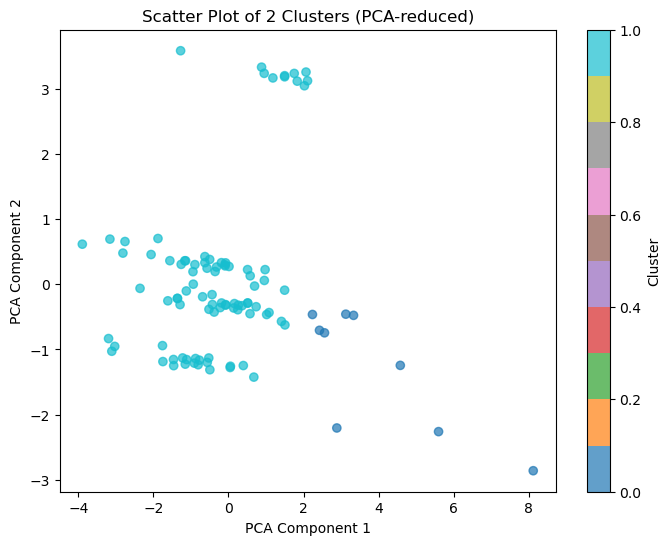

In [ ]:
# Fit KMeans with 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
clusters_2 = kmeans_2.fit_predict(cerv_risk_attr_transformed)

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(cerv_risk_attr_transformed)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_2, cmap='tab10', alpha=0.7)
plt.title('Scatter Plot of 2 Clusters (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [39]:
cerv_risk_attr['Cluster_2'] = clusters_2
cerv_risk_attr.head()

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Smoking Status,STDs History,Years_Sexually_Active,Smoking_Status_Num,STDs_History_Num,Risk_Score,Smokes_and_Has_STDs,Sexual_Partner_and_Years_Active,Log_Sexual_Partners,Years_Sexually_Active_Squared,Age_Group,HPV_Test_Result_Num,Cluster,Cluster_2
0,18,4,15,NEGATIVE,N,Y,3,0,1,1.900000,0,12,1.609438,9,<25,0,2,1
1,15,1,14,POSITIVE,Y,Y,1,1,1,2.233333,1,1,0.693147,1,<25,1,4,1
2,34,1,9,POSITIVE,N,Y,25,0,1,2.033333,0,25,0.693147,625,25-35,1,2,1
3,52,5,16,POSITIVE,Y,N,36,1,0,3.200000,0,180,1.791759,1296,50+,1,0,0
4,46,3,21,POSITIVE,N,N,25,0,0,1.433333,0,75,1.386294,625,36-50,1,1,1


In [40]:
summary_mean = cerv_risk_attr.groupby('Cluster_2').mean(numeric_only=True)
summary_median = cerv_risk_attr.groupby('Cluster_2').median(numeric_only=True)

print("Mean values per cluster:")
display(summary_mean)
print("Median values per cluster:")
display(summary_median)

Mean values per cluster:


,Age,Sexual Partners,First Sexual Activity Age,Years_Sexually_Active,Smoking_Status_Num,STDs_History_Num,Risk_Score,Smokes_and_Has_STDs,Sexual_Partner_and_Years_Active,Log_Sexual_Partners,Years_Sexually_Active_Squared,HPV_Test_Result_Num,Cluster
Cluster_2,,,,,,,,,,,,,
0,60.333333,4.111111,16.666667,43.666667,0.222222,0.666667,3.166667,0.000000,149.888889,1.535942,2217.888889,0.666667,0.666667
1,35.344444,2.611111,19.233333,16.111111,0.422222,0.466667,1.948148,0.122222,43.888889,1.223580,323.888889,0.500000,1.700000


Median values per cluster:


,Age,Sexual Partners,First Sexual Activity Age,Years_Sexually_Active,Smoking_Status_Num,STDs_History_Num,Risk_Score,Smokes_and_Has_STDs,Sexual_Partner_and_Years_Active,Log_Sexual_Partners,Years_Sexually_Active_Squared,HPV_Test_Result_Num,Cluster
Cluster_2,,,,,,,,,,,,,
0,59.0,4.0,17.0,37.0,0.0,1.0,3.200000,0.0,141.0,1.609438,1369.0,1.0,0.0
1,36.0,3.0,18.0,18.0,0.0,0.0,2.033333,0.0,45.0,1.386294,324.0,0.5,1.0


In [47]:
# cross validation
silhouette_scores = []
for i in range(10):
    kmeans_temp = KMeans(n_clusters=2, random_state=i)
    clusters_temp = kmeans_temp.fit_predict(cerv_risk_attr_transformed)
    score = silhouette_score(cerv_risk_attr_transformed, clusters_temp)
    silhouette_scores.append(score)

print(f"Mean silhouette score over 10 iterations: {np.mean(silhouette_scores):.3f}")
print(f"Standard deviation of silhouette scores: {np.std(silhouette_scores):.3f}")

Mean silhouette score over 10 iterations: 0.258
Standard deviation of silhouette scores: 0.052


In [48]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(cerv_risk_attr_transformed, clusters_2)

kmeans_selected = KMeans(n_clusters=2, random_state=42)
clusters_selected = kmeans_selected.fit_predict(X_new)
selected_silhouette_score = silhouette_score(X_new, clusters_selected)

print(f"Selected Features Silhouette Score: {selected_silhouette_score:.3f}")

Selected Features Silhouette Score: 0.585


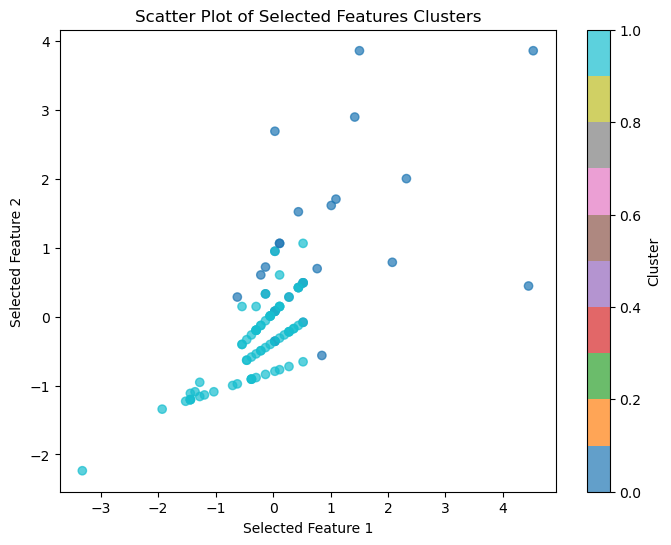

In [49]:
# visualize selected clusters
plt.figure(figsize=(8, 6))
scatter_selected = plt.scatter(X_new[:, 0], X_new[:, 1], c=clusters_selected, cmap='tab10', alpha=0.7)
plt.title('Scatter Plot of Selected Features Clusters')
plt.xlabel('Selected Feature 1')
plt.ylabel('Selected Feature 2')
plt.colorbar(scatter_selected, label='Cluster')
plt.show()

In [ ]:
joblib.dump(kmeans_selected, 'cervical_cancer_kmeans_selected_model.pkl')
joblib.dump(selector, 'cervical_cancer_feature_selector.pkl')
joblib.dump(full_risk_pipeine, 'cervical_cancer_risk_pipeline.pkl')

selected_features = selector.get_support(indices=True)
feature_names = num_attr + list(full_risk_pipeine.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_attr))
selected_feature_names = [feature_names[i] for i in selected_features]

import pickle
with open('selected_feature_names.pkl', 'wb') as f:
    pickle.dump(selected_feature_names, f)

print(f"Selected features: {selected_feature_names}")
print(f"Selected Features Silhouette Score: {selected_silhouette_score:.3f}")

Selected features: ['Years_Sexually_Active', 'Sexual_Partner_and_Years_Active', 'Years_Sexually_Active_Squared', 'High_Risk_Score', 'Age_Group_50+']
Selected Features Silhouette Score: 0.585


## Save model

In [356]:
joblib.dump(kmeans_6, 'cervical_cancer_kmeans_model.pkl')
joblib.dump(imputer, 'cervical_cancer_imputer.pkl')

['cervical_cancer_imputer.pkl']

In [358]:
# scaler
joblib.dump(scaler, 'cervical_cancer_minmax_scaler.pkl')
joblib.dump(std_scaler, 'cervical_cancer_std_scaler.pkl')

['cervical_cancer_std_scaler.pkl']

## PREDICTING RECOMMENDED ACTION

In [22]:
cerv_df

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action
0,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE
1,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
2,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
3,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION"
4,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
...,...,...,...,...,...,...,...,...,...,...,...
95,31,4,16,POSITIVE,Y,Y,N,Machakos,N,PAP SMEAR,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"
96,35,5,11,NEGATIVE,N,Y,N,Mombasa,N,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS
97,35,1,18,POSITIVE,N,Y,N,Kericho,N,HPV DNA,FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS
98,31,1,20,POSITIVE,Y,Y,N,Embu,Y,HPV DNA,"FOR COLPOSCOPY BIOPSY, CYTOLOGY"


Since most of the data has been understood, the following preprocessing will be done:
- dropping the region and insurance features
- binning the age feature
- getting the sexually active years
- transforming the sexual partners and sexual activity age
- converting the categorical features to numerical (hpv test result, pap smear result, smoking status, std history, screening type last)
    - for the hpv test and pap smear, default will be negative the the patient didn't get one

### Data Cleaning

In [23]:
# drop unnecessary columns
cerv_df = cerv_df.drop(columns=['Region', 'Insrance Covered'], axis=1)
cerv_df.head()

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Screening Type Last,Recommended Action
0,18,4,15,NEGATIVE,N,N,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE
1,15,1,14,POSITIVE,N,Y,Y,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
2,34,1,9,POSITIVE,N,N,Y,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION
3,52,5,16,POSITIVE,N,Y,N,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION"
4,46,3,21,POSITIVE,N,N,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION


### Feature Engineering

In [24]:
smoking_map = {'N': 0, 'Y': 1}
stds_map = {'N': 0, 'Y': 1}
pap_smear_map = {'N': 0, 'Y': 1}
hpv_map = {'NEGATIVE': 0, 'POSITIVE': 1}

cerv_df['Smoking_Status_Num'] = cerv_df['Smoking Status'].map(smoking_map)
cerv_df['STDs_History_Num'] = cerv_df['STDs History'].map(stds_map)

cerv_df['Pap_Smear_Result_Num'] = cerv_df['Pap Smear Result'].map(pap_smear_map)
cerv_df['HPV_Test_Result_Num'] = cerv_df['HPV Test Result'].map(hpv_map)
cerv_df['Age_Group'] = pd.cut(cerv_df['Age'], bins=[0, 25, 35, 50, 100], labels=['<25', '25-35', '36-50', '50+'])
cerv_df['Years_Sexually_Active'] = cerv_df['Age'] - cerv_df['First Sexual Activity Age']
cerv_df['Smokes_and_Has_STDs'] = cerv_df['Smoking_Status_Num'] * cerv_df['STDs_History_Num']
cerv_df['Sexual_Partner_and_Years_Active'] = cerv_df['Sexual Partners'] * cerv_df['Years_Sexually_Active']
cerv_df['Risk_Score'] = (cerv_df['Sexual Partners'] / 5 + (cerv_df['Years_Sexually_Active'] / 30) + cerv_df['Smoking_Status_Num'] + cerv_df['STDs_History_Num'])
cerv_df['Log_Sexual_Partners'] = np.log1p(cerv_df['Sexual Partners'])
cerv_df['Years_Sexually_Active_Squared'] = cerv_df['Years_Sexually_Active'] ** 2

cerv_df.head(5)

,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Screening Type Last,Recommended Action,Smoking_Status_Num,STDs_History_Num,Pap_Smear_Result_Num,HPV_Test_Result_Num,Age_Group,Years_Sexually_Active,Smokes_and_Has_STDs,Sexual_Partner_and_Years_Active,Risk_Score,Log_Sexual_Partners,Years_Sexually_Active_Squared
0,18,4,15,NEGATIVE,N,N,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,0,1,0,0,<25,3,0,12,1.900000,1.609438,9
1,15,1,14,POSITIVE,N,Y,Y,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,1,1,0,1,<25,1,1,1,2.233333,0.693147,1
2,34,1,9,POSITIVE,N,N,Y,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,0,1,0,1,25-35,25,0,25,2.033333,0.693147,625
3,52,5,16,POSITIVE,N,Y,N,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",1,0,0,1,50+,36,0,180,3.200000,1.791759,1296
4,46,3,21,POSITIVE,N,N,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,0,0,0,1,36-50,25,0,75,1.433333,1.386294,625


In [25]:
cerv_df.isna().sum()

Age                                0
Sexual Partners                    0
First Sexual Activity Age          0
HPV Test Result                    0
Pap Smear Result                   0
Smoking Status                     0
STDs History                       0
Screening Type Last                0
Recommended Action                 0
Smoking_Status_Num                 0
STDs_History_Num                   0
Pap_Smear_Result_Num               0
HPV_Test_Result_Num                0
Age_Group                          0
Years_Sexually_Active              0
Smokes_and_Has_STDs                0
Sexual_Partner_and_Years_Active    0
Risk_Score                         0
Log_Sexual_Partners                0
Years_Sexually_Active_Squared      0
dtype: int64

In [26]:
cerv_df = cerv_df.drop(columns=['Smoking Status', 'STDs History', 'First Sexual Activity Age', 'Age', 'HPV Test Result', 'Pap Smear Result', 'Sexual Partners'], axis=1)
cerv_df.head()

,Screening Type Last,Recommended Action,Smoking_Status_Num,STDs_History_Num,Pap_Smear_Result_Num,HPV_Test_Result_Num,Age_Group,Years_Sexually_Active,Smokes_and_Has_STDs,Sexual_Partner_and_Years_Active,Risk_Score,Log_Sexual_Partners,Years_Sexually_Active_Squared
0,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,0,1,0,0,<25,3,0,12,1.900000,1.609438,9
1,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,1,1,0,1,<25,1,1,1,2.233333,0.693147,1
2,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,0,1,0,1,25-35,25,0,25,2.033333,0.693147,625
3,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",1,0,0,1,50+,36,0,180,3.200000,1.791759,1296
4,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,0,0,0,1,36-50,25,0,75,1.433333,1.386294,625


In [27]:
# encode recommended action target variable
cerv_df['Recommended Action'].value_counts()

Recommended Action
REPEAT PAP SMEAR IN 3 YEARS                                 25
FOR COLPOSCOPY BIOPSY, CYTOLOGY                             11
FOR PAP SMEAR                                                9
FOR HPV VACCINE AND SEXUAL EDUCATION                         7
FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS                 7
FOR ANNUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS                5
REPEAT PAP SMEAR IN 3 YEARS                                  5
FOR COLPOSCOPY BIOPSY, CYTOLOGY                              5
FOR COLPOSCOPY BIOSPY, CYTOLOGY                              4
FOR HPV VACCINATION AND SEXUAL EDUCATION                     2
REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE              2
FOR COLOSCOPY BIOSY, CYTOLOGY                                2
FOR COLPOSCOPY CYTOLOGY AND BIOPSY                           1
FOR BIOPSY AND CYTOLOGY WITH TAH NOT RECOMMENDED             1
FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION              1
FOR COLPOSCOPY BIOSY, CYTOLOGY+/- TA

In [28]:
action_standardization_map = {
    "REPEAT PAP SMEAR IN 3 YEARS": "REPEAT PAP SMEAR IN 3 YEARS",
    "REPEAT PAP SMEAR IN 3YEARS": "REPEAT PAP SMEAR IN 3 YEARS",
    "FOR PAP SMEAR": "FOR PAP SMEAR",
    "FOR HPV VACCINE AND SEXUAL EDUCATION": "FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",
    "FOR HPV VACCINATION AND SEXUAL EDUCATION": "FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",
    "FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION": "FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",
    "FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS": "FOR ANNUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS",
    "FOR ANNUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS": "FOR ANNUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS",
    "REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE": "REPEAT PAP SMEAR IN 3 YEARS",
    "FOR COLPOSCOPY BIOPSY, CYTOLOGY": "FOR COLPOSCOPY BIOPSY, CYTOLOGY",
    "FOR COLPOSCOPY BIOSPY, CYTOLOGY": "FOR COLPOSCOPY BIOPSY, CYTOLOGY",
    "FOR COLOSCOPY BIOSY, CYTOLOGY": "FOR COLPOSCOPY BIOPSY, CYTOLOGY",
    "FOR COLPOSCOPY CYTOLOGY AND BIOPSY": "FOR COLPOSCOPY BIOPSY, CYTOLOGY",
    "FOR COLPOSCPY BIOPSY, CYTOLOGY": "FOR COLPOSCOPY BIOPSY, CYTOLOGY",
    "FOR COLPOSCOPY BIOSY, CYTOLOGY+/- TAH": "FOR COLPOSCOPY BIOPSY, CYTOLOGY+/- TAH",
    "FOR COLPOSCOPY BIOPSY, CYTOLOGY +/- TAH": "FOR COLPOSCOPY BIOPSY, CYTOLOGY+/- TAH",
    "FOR COLPOSCOPY BIOPSY, CYTOLOGY+/- TAH": "FOR COLPOSCOPY BIOPSY, CYTOLOGY+/- TAH",
    "FOR COLPOSCOPY BIOPSY, CYTOLOGY +/-TAH": "FOR COLPOSCOPY BIOPSY, CYTOLOGY+/- TAH",
    "FOR COLPOSCOPY BIOPSY AND CYTOLOGY+/- TAH": "FOR COLPOSCOPY BIOPSY, CYTOLOGY+/- TAH",
    "FOR BIOPSY AND CYTOLOGY WITH TAH NOT RECOMMENDED": "FOR COLPOSCOPY BIOPSY, CYTOLOGY WITH TAH NOT RECOMMENDED",
    "FOR COLPOSCOPY BIOPSY, CYTOLOGY WITH TAH NOT RECOMMENDED": "FOR COLPOSCOPY BIOPSY, CYTOLOGY WITH TAH NOT RECOMMENDED",
    "FOR COLPOSOCPY BIOPSY, CYTOLOGY WITH TAH NOT RECOMMENDED": "FOR COLPOSCOPY BIOPSY, CYTOLOGY WITH TAH NOT RECOMMENDED",
    "FOR LASER THERAPY": "FOR LASER THERAPY",
    "FORCOLPOSCOPY, CYTOLOGY THEN LASER THERAPY": "FOR COLPOSCOPY, CYTOLOGY THEN LASER THERAPY",
    "FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS": "FOR ANNUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS",
}

def standardize_action(text):
    if pd.isna(text):
        return "UNKNOWN"
    t = str(text).strip().upper()
    # Try direct match first
    if t in action_standardization_map:
        return action_standardization_map[t]
    # Try to match after removing extra spaces
    t_clean = " ".join(t.split())
    for k, v in action_standardization_map.items():
        if t_clean == k:
            return v
    return t_clean  

# Apply the standardization
cerv_df['Recommended Action'] = cerv_df['Recommended Action'].apply(standardize_action)

# Show the new value counts to verify
cerv_df['Recommended Action'].value_counts()


Recommended Action
REPEAT PAP SMEAR IN 3 YEARS                                 33
FOR COLPOSCOPY BIOPSY, CYTOLOGY                             24
FOR ANNUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS               13
FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION             10
FOR PAP SMEAR                                               10
FOR COLPOSCOPY BIOPSY, CYTOLOGY+/- TAH                       4
FOR COLPOSCOPY BIOPSY, CYTOLOGY WITH TAH NOT RECOMMENDED     2
FOR LASER THERAPY                                            1
FOR COLPOSCOPY BIOSPY, CYTOLOGY +/- TAH                      1
FOR COLPOSCOPY, CYTOLOGY THEN LASER THERAPY                  1
Name: count, dtype: int64

### Grouping "Recommended Action" into Four Categories

In [29]:
def group_action(cleaned_action):
    if cleaned_action in [
        "REPEAT PAP SMEAR IN 3 YEARS",
        "FOR PAP SMEAR",
        "FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION"
    ]:
        return "Screening"
    elif cleaned_action in [
        "FOR ANNUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS",
        "REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE",
        
    ]:
        return "Follow up"
    elif cleaned_action in [
        "FOR COLPOSCOPY BIOPSY, CYTOLOGY",
        "FOR COLPOSCOPY BIOPSY, CYTOLOGY+/- TAH",
        "FOR COLPOSCOPY BIOPSY, CYTOLOGY WITH TAH NOT RECOMMENDED",
        "FOR LASER THERAPY",
        "FOR COLPOSCOPY, CYTOLOGY THEN LASER THERAPY",

    ]:
        return "Diagnostic evaluation and treatment"
    else:
        return "Other"

In [30]:
cerv_df['Recommended Action Grouped'] = cerv_df['Recommended Action'].apply(group_action)
cerv_df['Recommended Action Grouped'].value_counts()

Recommended Action Grouped
Screening                              53
Diagnostic evaluation and treatment    32
Follow up                              13
Other                                   1
Name: count, dtype: int64

In [31]:
cerv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 0 to 99
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Screening Type Last              99 non-null     object  
 1   Recommended Action               99 non-null     object  
 2   Smoking_Status_Num               99 non-null     int64   
 3   STDs_History_Num                 99 non-null     int64   
 4   Pap_Smear_Result_Num             99 non-null     int64   
 5   HPV_Test_Result_Num              99 non-null     int64   
 6   Age_Group                        99 non-null     category
 7   Years_Sexually_Active            99 non-null     int64   
 8   Smokes_and_Has_STDs              99 non-null     int64   
 9   Sexual_Partner_and_Years_Active  99 non-null     int64   
 10  Risk_Score                       99 non-null     float64 
 11  Log_Sexual_Partners              99 non-null     float64 
 12  Years_Sexually_

In [32]:
# drop unknown rows
cerv_df = cerv_df[cerv_df['Recommended Action Grouped'] != 'Other']

In [33]:
cerv_df.shape

(98, 14)

In [34]:
cerv_df = cerv_df.drop(columns=['Recommended Action'], axis=1)
cerv_df.head()

,Screening Type Last,Smoking_Status_Num,STDs_History_Num,Pap_Smear_Result_Num,HPV_Test_Result_Num,Age_Group,Years_Sexually_Active,Smokes_and_Has_STDs,Sexual_Partner_and_Years_Active,Risk_Score,Log_Sexual_Partners,Years_Sexually_Active_Squared,Recommended Action Grouped
0,PAP SMEAR,0,1,0,0,<25,3,0,12,1.900000,1.609438,9,Screening
1,HPV DNA,1,1,0,1,<25,1,1,1,2.233333,0.693147,1,Screening
2,HPV DNA,0,1,0,1,25-35,25,0,25,2.033333,0.693147,625,Screening
3,HPV DNA,1,0,0,1,50+,36,0,180,3.200000,1.791759,1296,Screening
4,HPV DNA,0,0,0,1,36-50,25,0,75,1.433333,1.386294,625,Screening


In [35]:
cerv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Screening Type Last              98 non-null     object  
 1   Smoking_Status_Num               98 non-null     int64   
 2   STDs_History_Num                 98 non-null     int64   
 3   Pap_Smear_Result_Num             98 non-null     int64   
 4   HPV_Test_Result_Num              98 non-null     int64   
 5   Age_Group                        98 non-null     category
 6   Years_Sexually_Active            98 non-null     int64   
 7   Smokes_and_Has_STDs              98 non-null     int64   
 8   Sexual_Partner_and_Years_Active  98 non-null     int64   
 9   Risk_Score                       98 non-null     float64 
 10  Log_Sexual_Partners              98 non-null     float64 
 11  Years_Sexually_Active_Squared    98 non-null     int64   
 12  Recommended Act

In [36]:
cat_attr = ['Age_Group', 'Screening Type Last']
num_attr = ['Smoking_Status_Num', 'STDs_History_Num', 'Years_Sexually_Active', 'Smokes_and_Has_STDs',
            'Sexual_Partner_and_Years_Active', 'Risk_Score', 'Log_Sexual_Partners', 'Years_Sexually_Active_Squared', 'Pap_Smear_Result_Num', 'HPV_Test_Result_Num']

labels = cerv_df['Recommended Action Grouped'].values

In [37]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(cerv_df, labels):
    train_set = cerv_df.iloc[train_index]
    test_set = cerv_df.iloc[test_index]

train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [38]:
train_set.head()

,Screening Type Last,Smoking_Status_Num,STDs_History_Num,Pap_Smear_Result_Num,HPV_Test_Result_Num,Age_Group,Years_Sexually_Active,Smokes_and_Has_STDs,Sexual_Partner_and_Years_Active,Risk_Score,Log_Sexual_Partners,Years_Sexually_Active_Squared,Recommended Action Grouped
0,PAP SMEAR,0,1,1,1,36-50,31,0,124,2.833333,1.609438,961,Diagnostic evaluation and treatment
1,VIA,1,0,0,0,25-35,20,0,100,2.666667,1.791759,400,Screening
2,VIA,0,0,0,0,36-50,25,0,50,1.233333,1.098612,625,Screening
3,PAP SMEAR,1,0,0,0,25-35,0,0,0,1.200000,0.693147,0,Screening
4,VIA,1,1,0,0,36-50,19,1,38,3.033333,1.098612,361,Screening


In [39]:
cerv_df_prepared = train_set.drop(columns=['Recommended Action Grouped'], axis=1)

In [40]:
cerv_df_labels = train_set['Recommended Action Grouped']

In [41]:
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(sparse_output=False))
    ]
)

full_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_attr),
        ('cat', cat_pipeline, cat_attr)
    ]
)

In [42]:
cerv_df_prepared = full_pipeline.fit_transform(cerv_df_prepared)

In [43]:
cerv_df_prepared

array([[-8.12141901e-01,  1.05266714e+00,  1.01242865e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.23131192e+00, -9.49967907e-01,  1.54912577e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-8.12141901e-01, -9.49967907e-01,  5.44692608e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [-8.12141901e-01,  1.05266714e+00, -9.99435978e-04, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.23131192e+00, -9.49967907e-01,  4.66736602e-01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.12141901e-01,  1.05266714e+00, -7.89554422e-02, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]],
      shape=(78, 17))

In [44]:
cerv_df_labels = OneHotEncoder(sparse_output=False).fit_transform(cerv_df_labels.values.reshape(-1, 1))

In [45]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)

In [46]:
test_set_prepared = full_pipeline.transform(test_set.drop(columns=['Recommended Action Grouped'], axis=1))
test_set_labels = OneHotEncoder(sparse_output=False).fit_transform(test_set['Recommended Action Grouped'].values.reshape(-1, 1))


### Decision Tree

Decision Tree Accuracy: 0.650
Decision Tree F1 Score: 0.683


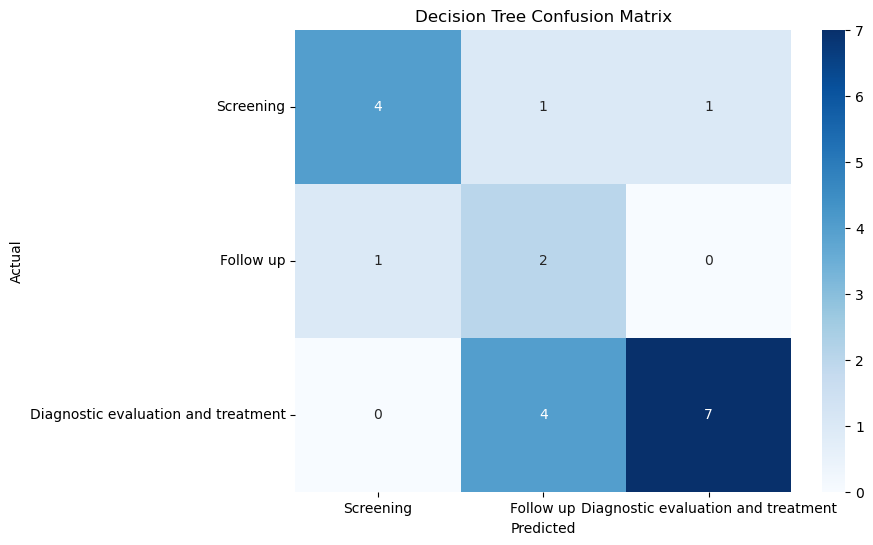

In [47]:
dt_model.fit(cerv_df_prepared, cerv_df_labels)
tree_predictions = dt_model.predict(test_set_prepared)
tree_accuracy = accuracy_score(test_set_labels, tree_predictions)
print(f"Decision Tree Accuracy: {tree_accuracy:.3f}")


# f1 score
tree_f1 = f1_score(test_set_labels, tree_predictions, average='weighted')
print(f"Decision Tree F1 Score: {tree_f1:.3f}")

# confusion matrix
tree_cm = confusion_matrix(test_set_labels.argmax(axis=1), tree_predictions.argmax(axis=1
))
plt.figure(figsize=(8, 6))  
sns.heatmap(tree_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Screening', 'Follow up', 'Diagnostic evaluation and treatment'], yticklabels=['Screening', 'Follow up', 'Diagnostic evaluation and treatment'])
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Random Forest Classifier

Random Forest Accuracy: 0.800
Random Forest F1 Score: 0.825


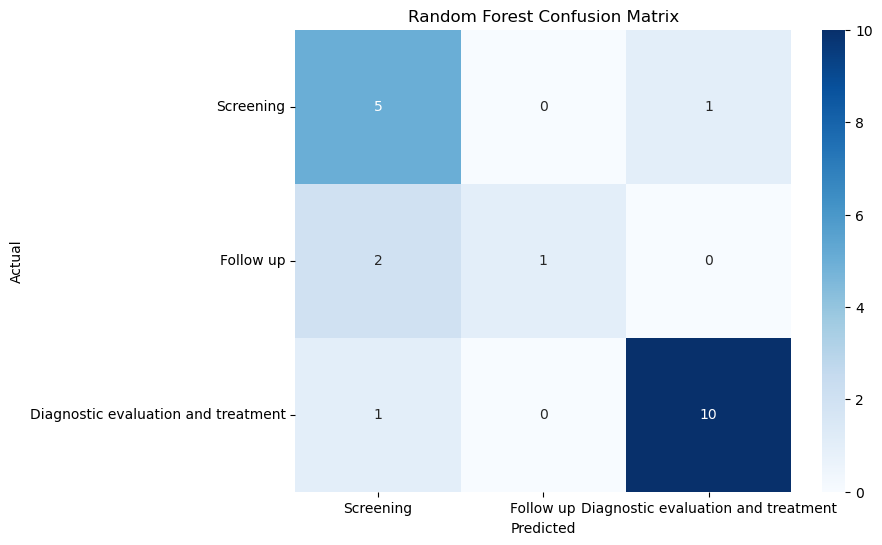

In [48]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(cerv_df_prepared, cerv_df_labels)
rf_predictions = rf_model.predict(test_set_prepared)
rf_accuracy = accuracy_score(test_set_labels, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.3f}")
# f1 score
rf_f1 = f1_score(test_set_labels, rf_predictions, average='weighted')
print(f"Random Forest F1 Score: {rf_f1:.3f}")
# confusion matrix
rf_cm = confusion_matrix(test_set_labels.argmax(axis=1), rf_predictions.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Screening', 'Follow up', 'Diagnostic evaluation and treatment'], yticklabels=['Screening', 'Follow up', 'Diagnostic evaluation and treatment'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### KNearest Neighbours

  File "C:\Users\angie\Desktop\shescreen\shescreen_DS\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\angie\Desktop\shescreen\shescreen_DS\env\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\angie\Desktop\shescreen\shescreen_DS\env\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^

KNN Accuracy: 0.700
KNN F1 Score: 0.680


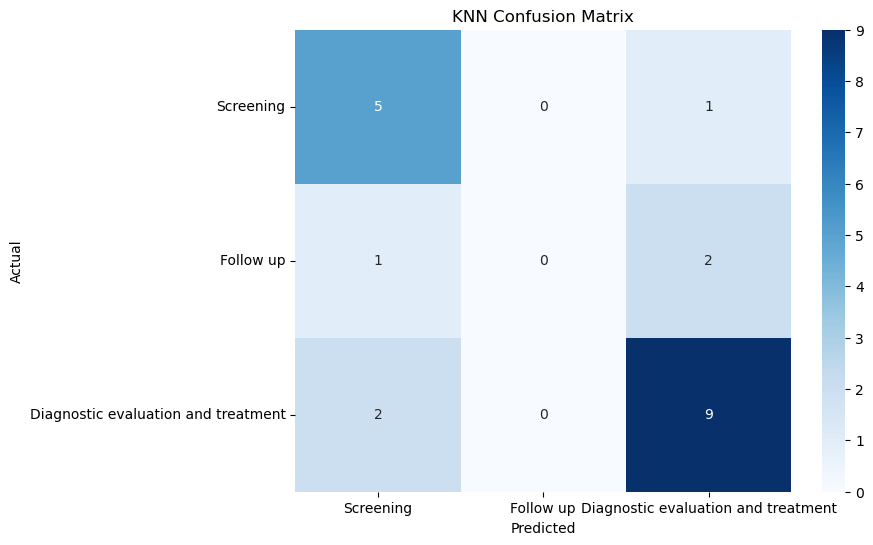

In [49]:
knn_model.fit(cerv_df_prepared, cerv_df_labels)
knn_predictions = knn_model.predict(test_set_prepared)  
knn_accuracy = accuracy_score(test_set_labels, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy:.3f}")

# f1 score
knn_f1 = f1_score(test_set_labels, knn_predictions, average='weighted')
print(f"KNN F1 Score: {knn_f1:.3f}")

# confusion matrix
knn_cm = confusion_matrix(test_set_labels.argmax(axis=1), knn_predictions.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Screening', 'Follow up', 'Diagnostic evaluation and treatment'], yticklabels=['Screening', 'Follow up', 'Diagnostic evaluation and treatment'])
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Out of the 3 models:
- Random forest is giving the best performance

Next steps:

    - finetuning the Random Forest Classifier
    - Feature importance
    - Undoing the engineered features
    - If mode performs better with the changes -> deploy model

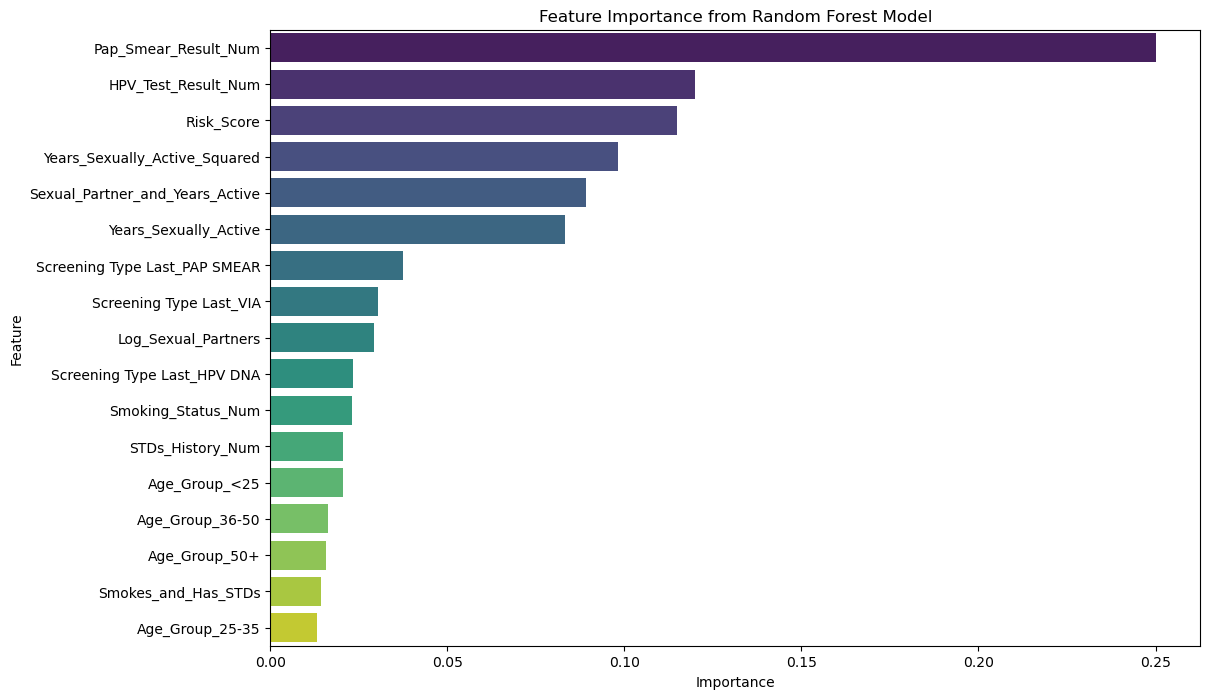

In [50]:
# feature importance for Random Forest
importances = rf_model.feature_importances_
feature_names = num_attr + list(full_pipeline.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_attr))
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [51]:
# classofication report for Random Forest
rf_classification_report = classification_report(test_set_labels.argmax(axis=1), rf_predictions.argmax(axis=1), target_names=['Screening', 'Follow up', 'Diagnostic evaluation and treatment'])
print("Random Forest Classification Report:\n", rf_classification_report)   


Random Forest Classification Report:
                                      precision    recall  f1-score   support

                          Screening       0.62      0.83      0.71         6
                          Follow up       1.00      0.33      0.50         3
Diagnostic evaluation and treatment       0.91      0.91      0.91        11

                           accuracy                           0.80        20
                          macro avg       0.84      0.69      0.71        20
                       weighted avg       0.84      0.80      0.79        20



In [52]:
# save model
joblib.dump(rf_model, 'cervical_cancer_rf_model.pkl')

['cervical_cancer_rf_model.pkl']

In [53]:
# save pipelines
joblib.dump(full_pipeline, 'cervical_cancer_full_pipeline.pkl')

['cervical_cancer_full_pipeline.pkl']